***
# Residual analysis of the Astrometric Reference Catalogues
***

<div class="alert alert-block alert-info"> This Jupyter Notebook serves as additional guideline for Chapter 8 in my Master Thesis. All code used to analyse data and produce plots is presented here 

</div>


<font color="#31688e">   <i>
In this chapter we will mainly focus on (i) and (ii) which from now on will be referred to as $\textit{IR residuals, $\texttt{RES}_{\text{IR}}$}$, and $\textit{CR residuals, $\texttt{RES}_{\text{CR}}$}$. We will perform three experiments to investigate the $\texttt{Astrometric- Solution}$s obtained for SA 113s $\texttt{CelestialObject}$s.     
    
</i>   </font>

<b>
We start with our initial Master Catalogue set-up after the update of new Gaia DR2 astrometrical solutions. By using associations between different astrometrical solutions for the same celestial objects, we will determine position residuals. Statistical analysis of these position residuals will allow us to discuss and make statements about the improvements in astrometry as we improve our calibration
</b>



<div class="alert alert-block alert-info">
<b>  List of content of Chapter 8</b> <br>
<i> Figure and Table numbers refer to the numbers in the thesis </i>
    <br> <br>

[8.1](#8.1) <b>Defining astrometry Residuals</b> . . . . . . . . . . . . . . . . . . . . . . . .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .  . . . . .<br>
[8.2](#8.2) <b>Experiment 1: Instrumental astrometry vs. 'real' USNO-B1.0 positions</b> . . . . . . . . . . . . . . .  . . . . . [Figure 8.1](#figure1) <br>
[8.3](#8.3) <b>Experiment 2: Calibrated USNO-B1.0 versus reference catalogue astrometry</b> . .  . . . . . . . . . . . . [Figure 8.2](#figure2) <br>
[6.4](#8.4) <b>Experiment 3: Calibrated GAIA-DR2 versus reference catalogue astrometry</b> . . . . . . . . . . . . . . . [Figure 8.3](#figure3)<br>
[6.5](#8.5) <b>Conclusions of Residual Analyses</b> . . . . . . . . . . . . . . . . . . . .  . . . . . . . . . . . . . .  . . . . . . . . . . . . . . . . . . .  . . . . .

</div>


In [1]:
from __future__ import print_function

import warnings
warnings.filterwarnings("ignore")
%run py/setup_awe

try:
    context.set_project('OMEGACAM@VST')
    context.set_privileges(3)
    radec_SA113=[325.375,0.499]
    ra_SA113,dec_SA113,dra_SA113,ddec_SA113=radec_SA113[0],radec_SA113[1],1.,1.
    radec_SA107=[234.825,-0.263] 
    ra_SA107,dec_SA107,dra_SA107,ddec_SA107=radec_SA107[0],radec_SA107[1],1.,1.
except NameError as err:
    print("NameError: Module Context not imported, go to AW environment")
    pass


ImportError: Module Context not imported, go to AW environment
NameError: Module Context not imported, go to AW environment


In [2]:
import sqlite3
import pickle
import datetime
import numpy as np
try: 
    import pandas as pd
    import seaborn as sns
    from scipy.stats import norm, gamma
    import scipy.stats
    from pandas.plotting import register_matplotlib_converters
    register_matplotlib_converters()

except ImportError as err:
    print("ImportError: Python pandas module not imported, not available in Astro-WISE environment")
    import sqlite3
    pass

import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.cm as cmx
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib.ticker import FixedLocator, FixedFormatter

import matplotlib.dates as dates



import sys
import os

sys.path.insert(1,"../../pythonscripts/")

from Astrom import AstromAW

import pixel2radec as p2rd
import select_from_awedb as slct
import plotutils_awe as pltut


def _to_hex(c):
    """Convert arbitray color specification to hex string.
    
    Usage: 
        color = _to_hex((0.267004, 0.004874, 0.329415)) 
    Returns:
        HEX colors in the form of #440154
    
    """
    ctype = type(c)

    # Convert rgb to hex.
    if ctype is tuple or ctype is np.ndarray or ctype is list:
        return colors.rgb2hex(c)
    if ctype is str:
        # If color is already hex, simply return it.
        regex = re.compile('^#[A-Fa-f0-9]{6}$')
        if regex.match(c):
            return c
        # Convert named color to hex.
        return colors.cnames[c]
    raise Exception("Can't handle color of type: {}".format(ctype))

# Obtaining colors for scatter plot
purple = _to_hex((0.267004, 0.004874, 0.329415))
blue_purple = _to_hex((0.267968, 0.223549, 0.512008))
blue = _to_hex((0.190631, 0.407061, 0.556089))
green_blue = _to_hex((0.128729, 0.563265, 0.551229))
green_blue2 = _to_hex((0.288921, 0.758394, 0.428426))
green = _to_hex((0.20803, 0.718701, 0.472873))
yellow_green = _to_hex((0.555484, 0.840254, 0.269281))
yellow = _to_hex((0.993248, 0.906157, 0.143936)) 

# print(purple, blue_purple, blue, green_blue, green_blue2, green, yellow_green, yellow)

# Obtaining colors for exclusion zones
silver = _to_hex((0.93, 0.93, 0.93))
grey_blue = _to_hex((0.36, 0.48, 0.58))  
hist_purple = '#7F7FFF'  # the color used for all histograms, taking into acount its alpha
cum_red = 'FD0306' #the color used for all cumulative histogram plots

#print(silver, grey_blue)

In [3]:
sqlite_AID_tablefile = '../../mastertable/KiDS/mockupAIDTable.db'
sqlite_ALID_tablefile = '../../mastertable/KiDS/mockupALIDTable.db'
sqlite_SLID_tablefile = '../../mastertable/KiDS/mockupSLIDTable.db'
db_Master = "../../mastertable/KiDS/MasterTable.db"
db_Master = "../../mastertable/KiDS/MasterCatalogue.db"


def test_query(query, db_file="../../mastertable/KiDS/MasterCatalogue.db", p='no'):
    conn = sqlite3.connect(db_file)
    with conn:
        c = conn.cursor()
        c.execute(query)
    print("Query database for: '''{}'''".format(query))
    if p == 'yes':
        print("OUTPUT SQLITE > {}\n".format(c.fetchall()))
    else:
        print("To print OUTPUT query, set p to 'yes': test_query(query, db_file, p='yes')")
    return None

def run_query(query, output='tuple', db_file=db_Master):
    conn = sqlite3.connect(db_file)
    with conn:
        c = conn.cursor()
        c.execute(query)
    # The method fetches all rows of a query result set and returns a list of tuples.
    if output == 'tuple':
        return c.fetchall()
    elif output == 'array':
        try: 
            records=c.fetchall()
            nr_q = len(records)
            nr_columns = len(records[0])
            data = [[row[i] for row in records] for i in range(nr_columns)] 
            if len(data) == 1:
                return [[row[i] for row in records] for i in range(nr_columns)][0]
            else:
                return [[row[i] for row in records] for i in range(nr_columns)]  
        except IndexError as err:
            return [row[0] for row in records]
    else:
        print("AttibuteError: run_query() only takes output = 'tuple' or 'array' as input")
    return None
    
def _get_attrlist(table_name, db_file= "../../mastertable/KiDS/mockupMasterTable.db"):
    # attrlist_AID_SA_113 = _get_attrlist("AID_SA_113")
    # attrlist_ALID_SA_113 = _get_attrlist("ALID_SA_113")
    # attrlist_SLID_SA_113 = _get_attrlist("SLID_SA_113")
    query_attrlist = '''select * from pragma_table_info("{}")'''.format(table_name)
    attrlist_table = [q[1] for q in run_query(query_attrlist, db_file=DB)]
    return (attrlist_table)

def _get_slid_ids(table_name, db_file= "../../mastertable/KiDS/mockupMasterTable.db"):
    # slids_ALID_SA_113_master = _get_slid_ids("ALID_SA_113")[0]
    query_slid_ids = '''select DISTINCT SLID from {}'''.format(table_name)
    aslid_ids_table = [q[0] for q in run_query(query_slid_ids, db_file=DB)]
    return (aslid_ids_table)

def _get_obs_date(table_name, db_file= "../../mastertable/KiDS/mockupMasterTable.db"):
    # attrlist_te = _get_obs_date("SLID_SA_113")
    query_obs_date = '''select DISTINCT OBS_TIME from {}'''.format(table_name)
    obs_date_table = [q[0] for q in run_query(query_obs_date, db_file=DB)]
    return (obs_date_table)

def _get_unique_aid(slid, AID_table_name="AID_SA_113", db_file= "../../mastertable/KiDS/mockupMasterTable.db"):
    query_SLIDunique = '''SELECT DISTINCT AID_PAIR FROM {} WHERE AID_SLID1 IS {}'''.format(AID_table_name, slid)
    slids_unique = [q[0] for q in run_query(query_SLIDunique, db_file=DB)]
    return (slids_unique)

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script> <i>
The code used to load the data, plot the Figures & Tables and analyse the results is hidden by default.
To show the raw code, click  <a href="javascript:code_toggle()">here</a> </i>.''') 

<br><br>
[Go back to list of contents](#LOC)
<a id = "RES" RES></a>

***
# Residual analysis experiments
***

There are three main questions to be answered by the Table File System. Indirecly these questions are the main questions of this research as well:

1.  What are at this moment the known celestial object in the Universe?
*  What is there most accurate current position and proper motion, as known by our system?
*  Is it possible to improve the accuracy of the by us known celestial objects? If yes, do so.  




 Using the equations below, the astrometry residuals can be calculated. $\alpha$ represents the value for right ascension and $\delta$ for declination. The residual is the angular distance between the two positions on the sphere. 

$$
    \texttt{RES}_{\text{IR}} = \sqrt{((\alpha_{\text{ref}}-\alpha_{\text{instr}})\cdot\cos(\delta_{\text{ref}})  )^2 + (\delta^*_{\text{ref}}-\delta^*_{\text{instr}})^2} 
$$
$$
\label{eqn: CRres}
    \texttt{RES}_{\text{CR}} = \sqrt{((\alpha_{\text{ref}}-\alpha_{\text{cal}})\cdot\cos(\delta_{\text{ref}})  )^2 + + (\delta^*_{\text{ref}}-\delta^*_{\text{cal}})^2} 
$$




In [8]:
db_Master = "data/MasterCatalogue_resUSNO.db"  #2710361

generate_RAWMASTERtable(alid= 2710361, name= 'RawMasterTable', db_file=db_Master, transform='tan')

Connected to database...
Importing data from AssociateList with ALID 2710361
Commiting done...
Table stored as RawMasterTable in ../../mastertable/KiDS/MasterCatalogue_resUSNO.db


In [14]:
db_Master = "data/MasterCatalogue_resGAIA.db"   # 2709561    # --> SL gaia 76568851
generate_RAWMASTERtable(alid= 2709561, name= 'RawMasterTable', db_file=db_Master, transform='tan')


Connected to database...
Importing data from AssociateList with ALID 2709561
Commiting done...
Table stored as RawMasterTable in ../../mastertable/KiDS/MasterCatalogue_resGAIA.db



<br><br>

[Go back to list of contents](#LOC)

<a id = "5.1" LOC></a>
***
# Experiment 1: Instrumental astrometry vs. 'real' USNO-B1.0 positions
***





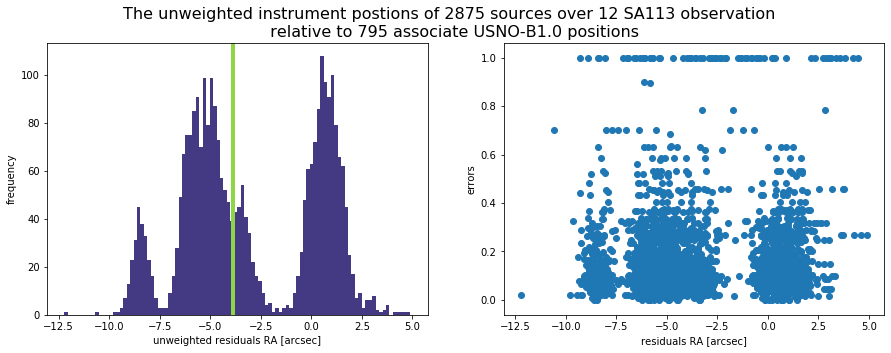

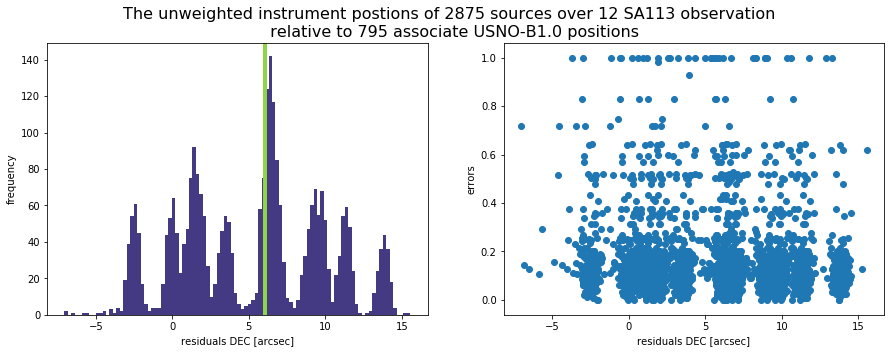

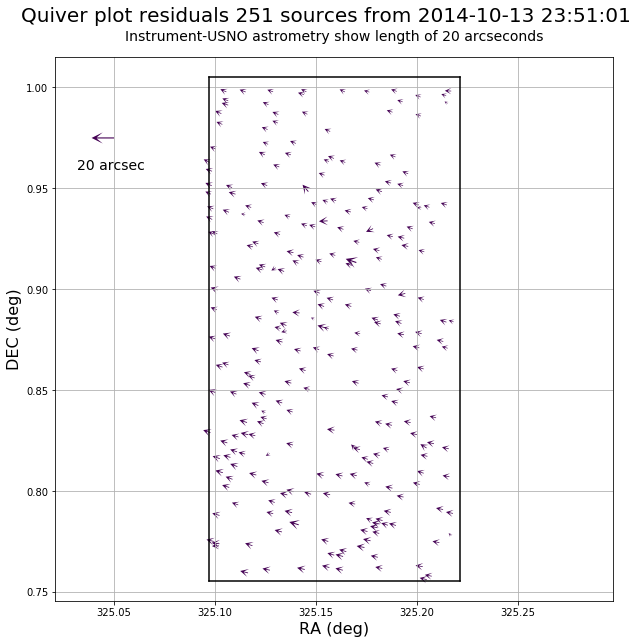

In [7]:
db_Master = "data/MasterCatalogue_resUSNO.db" 

refcat = ['USNO-B1.0', 'GAIA-DR2']
origin = ['OmegaCAM SA_113', 'USNO-B1.0', 'GAIA-DR2']
master_type = [0, 1, 2, 3]

query_select_masterid = '''SELECT DISTINCT TIME_OBS FROM MasterTable WHERE ORIGIN IS '{}';'''.format(origin[0])
obsTimes = run_query(query_select_masterid, db_file=db_Master, output='array')
nr_obs = len(obsTimes)

query_select_masterid = '''SELECT DISTINCT MASTER_ID FROM MasterTable WHERE ORIGIN IS '{}';'''.format(origin[0])
omega_ID = run_query(query_select_masterid, db_file=db_Master, output='array')
query_select_masteridunso = '''SELECT DISTINCT MASTER_ID FROM MasterTable WHERE ORIGIN IS '{}';'''.format(origin[1])
usno_ID = run_query(query_select_masteridunso, db_file=db_Master, output='array')
nr_usno = len(usno_ID)

# Obtaining all MASTER_IDs for which there is an association with UNSO-B1.0
# These sources can be used for our residual analysis according to METHOD 1
both_usno_omega_ID = list(set(omega_ID).intersection(usno_ID))

# Obtaining all MASTER_IDs for which there is no association with UNSO-B1.0
# Most of these sources therefore only have only one source extraction and no refcat
# These sources can be used for our residual analysis according to METHOD 2 [if more than one source extraction per MASTER_ID]
only_omega_ID = list(set(omega_ID).difference(usno_ID))

errors = 'unweighted' # or unweighted error

residual, resRA, resDec, residual_w, resRA_w, resDec_w = [], [], [], [], [], []
RAs, Decs, timeobs, error, errRA, errDec = [], [], [], [], [], []
count = 0
for master_id in both_usno_omega_ID:
    query_select_SE = '''SELECT MASTER_ID, RA, ERRX2_IMAGE, DEC, ERRY2_IMAGE, TIME_OBS FROM RawMasterTable WHERE ORIGIN IS '{}' AND MASTER_ID IS {};'''.format(origin[0], master_id, master_type[1])
    posSLID = run_query(query_select_SE, db_file=db_Master, output='tuple')
    query_select_CS = '''SELECT MASTER_ID, RA, RA_ERR, DEC, DEC_ERR FROM MasterTable WHERE ORIGIN IS '{}' AND MASTER_ID IS {} AND MASTER_TYPE IS {};'''.format(origin[1], master_id, master_type[0])
    posREF = run_query(query_select_CS, db_file=db_Master, output='tuple')[0]
    count = count + len(posSLID)
    
    diffPosSLID_REF = [np.sqrt( ((source[1]-posREF[1])*3600)**2 + ((source[3]-posREF[3])*3600)**2 ) for idx_source, source in enumerate(posSLID)]
    diffPosErrSLID_REF = [np.sqrt( source[2]**2 + source[4]**2 + (posREF[2]/1000)**2 + (posREF[4]/1000)**2 ) for idx_source, source in enumerate(posSLID)]
    
    diffRASLID_REF = [ (source[1]-posREF[1])*3600 for idx_source, source in enumerate(posSLID)]
    diffRAErrSLID_REF = [ np.sqrt((source[2]**2+(posREF[2]/1000)**2)) for idx_source, source in enumerate(posSLID)]
    diffDecSLID_REF = [ (source[3]-posREF[3])*3600 for idx_source, source in enumerate(posSLID)]
    diffDecErrSLID_REF = [ np.sqrt((source[4]**2+(posREF[4]/1000)**2)) for idx_source, source in enumerate(posSLID)]
    
    res_w = list(np.array(diffPosSLID_REF)/np.array(diffPosErrSLID_REF))
    resR_w = list(np.array(diffRASLID_REF)/np.array(diffRAErrSLID_REF))
    resD_w = list(np.array(diffDecSLID_REF)/np.array(diffDecErrSLID_REF))
    
    res = diffPosSLID_REF
    resR = diffRASLID_REF
    resD = diffDecSLID_REF
    
    residual_w.extend(res_w)
    resRA_w.extend(resR_w)
    resDec_w.extend(resD_w)   
    
    residual.extend(res)
    resRA.extend(resR)
    resDec.extend(resD)
    
    RAs.extend(list([source[1] for idx_source, source in enumerate(posSLID)]))
    Decs.extend(list([source[3] for idx_source, source in enumerate(posSLID)]))
    timeobs.extend(list([source[5] for idx_source, source in enumerate(posSLID)]))
    
    error.extend(diffPosErrSLID_REF)
    errRA.extend(diffRAErrSLID_REF)
    errDec.extend(diffDecErrSLID_REF)

fig, axes = plt.subplots(figsize=(15, 5), ncols=2, nrows=1)
fig.suptitle("The {} instrument postions of {} sources over {} SA113 observation \n relative to {} associate USNO-B1.0 positions".format(errors, count, nr_obs, nr_usno), fontsize=16)
ax = axes[0]
if errors == 'weighted':
    ax.hist(resRA_w, bins=100, range=(-0.1, 0.15), color=blue_purple)
elif errors == 'unweighted':
    ax.hist(resRA, bins=100, color=blue_purple)
ax.axvline(x=np.median(resRA), linewidth=4, color=yellow_green)
ax.set_xlabel("{} residuals RA [arcsec]".format(errors))
ax.set_ylabel("frequency")

ax = axes[1]
ax.scatter(resRA, errRA)
ax.set_xlabel('residuals RA [arcsec]')
ax.set_ylabel('errors')

fig, axes = plt.subplots(figsize=(15, 5), ncols=2, nrows=1)
fig.suptitle("The {} instrument postions of {} sources over {} SA113 observation \n relative to {} associate USNO-B1.0 positions".format(errors, count, nr_obs, nr_usno), fontsize=16)
ax = axes[0]
if errors == 'weighted':
    ax.hist(resDec, bins=100, range=(-0.1, 0.15), color=blue_purple)
elif errors == 'unweighted':
    ax.hist(resDec, bins=100, color=blue_purple)
ax.axvline(x=np.median(resDec), linewidth=4, color=yellow_green)
ax.set_xlabel('residuals DEC [arcsec]')
ax.set_ylabel('frequency')

ax = axes[1]
ax.scatter(resDec, errDec)
ax.set_xlabel('residuals DEC [arcsec]')
ax.set_ylabel('errors')

fig.show()


#  ---------- QUIVER PLOT

time_obs_unique = np.unique(timeobs)

ra_min, dec_min = min(RAs), min(Decs)
ra_max, dec_max = max(RAs), max(Decs)

fig, ax = plt.subplots(figsize=(10,10))

select_time = time_obs_unique[4]
time_mask = np.where(np.array(timeobs) == str(select_time))

q = ax.quiver(np.array(RAs)[time_mask], np.array(Decs)[time_mask], (np.array(resRA)/3600)[time_mask], (np.array(resDec)/3600)[time_mask], angles='xy', scale_units='xy', scale=0.5, linewidths=1, headlength=10, headwidth=10, width=0.002, color=purple)

ax.axis('equal')

ax.set_xlim(left=ra_min-0.01, right=ra_max+0.01)
ax.set_ylim(bottom=dec_min-0.01, top=dec_max+0.01)

for p in range(4):
    points = [[ra_min, dec_min], [ra_min, dec_max], [ra_max, dec_max], [ra_max, dec_min], [ra_min, dec_min]]
    x_values = [points[p][0], points[p+1][0]]
    y_values = [points[p][1], points[p+1][1]]
    plt.plot(x_values, y_values, c='k')

# legend
legend_arrow_size = 20
q = ax.quiver(325.05, 0.975, -legend_arrow_size/(3600), 0, angles='xy', scale_units='xy', scale=0.5, linewidths=1, headlength=10, headwidth=10, width=0.002, color=purple)
ax.text(0.1,  0.8, '{} arcsec'.format(legend_arrow_size), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=14,)         
     
fig.suptitle("Quiver plot residuals {} sources from {}".format(len(np.array(RAs)[time_mask]), select_time), fontsize=20, y=.95)
ax.set_title("Instrument-USNO astrometry show length of {} arcseconds".format(legend_arrow_size), fontsize=14, y=1.02)
ax.xaxis.set_label_text("RA (deg)", fontsize=16)
ax.yaxis.set_label_text("DEC (deg)", fontsize=16)


ax.grid(True)
plt.show()

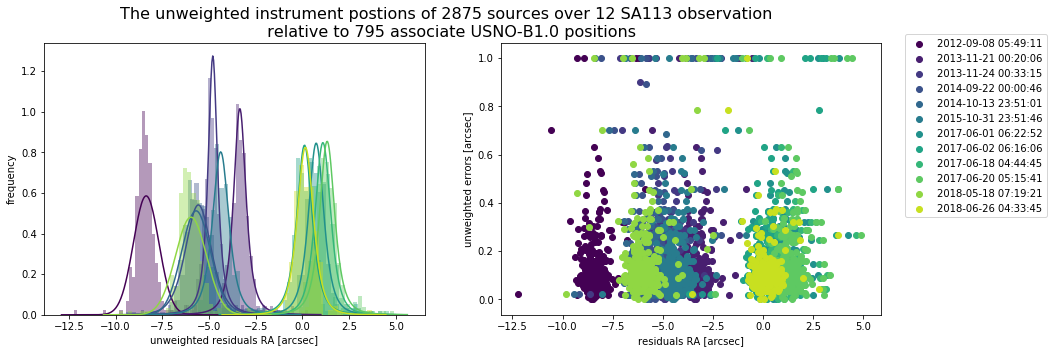

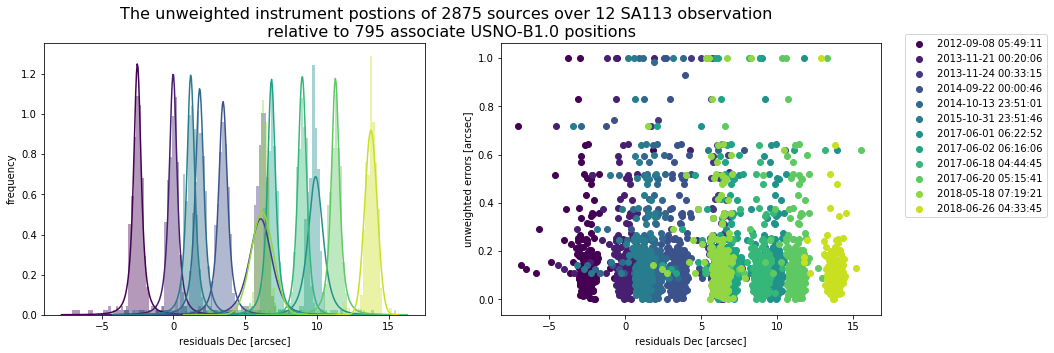

In [8]:
db_Master = "data/MasterCatalogue_resUSNO.db"


refcat = ['USNO-B1.0', 'GAIA-DR2', 'INSTRUMENT']
origin = ['OmegaCAM SA_113', 'USNO-B1.0', 'GAIA-DR2']
master_type = [0, 1, 2, 3]

# query_select_masterid = '''SELECT DISTINCT TIME_OBS FROM MasterTable WHERE ORIGIN IS '{}' AND REFCAT IS '{}';'''.format(origin[0], refcat[2])
query_select_masterid = '''SELECT DISTINCT TIME_OBS FROM MasterTable WHERE ORIGIN IS '{}';'''.format(origin[0])
obsTimes = run_query(query_select_masterid, db_file=db_Master, output='array')
nr_obs = len(obsTimes)

# query_select_masterid = '''SELECT DISTINCT MASTER_ID FROM MasterTable WHERE ORIGIN IS '{}' AND REFCAT IS '{}';'''.format(origin[0], refcat[2])
query_select_masterid = '''SELECT DISTINCT MASTER_ID FROM MasterTable WHERE ORIGIN IS '{}';'''.format(origin[0])
omega_ID = run_query(query_select_masterid, db_file=db_Master, output='array')
query_select_masteridunso = '''SELECT DISTINCT MASTER_ID FROM MasterTable WHERE ORIGIN IS '{}';'''.format(origin[1])
usno_ID = run_query(query_select_masteridunso, db_file=db_Master, output='array')
nr_usno = len(usno_ID)

# Obtaining all MASTER_IDs for which there is an association with UNSO-B1.0
# These sources can be used for our residual analysis according to METHOD 1
both_usno_omega_ID = list(set(omega_ID).intersection(usno_ID))

# Obtaining all MASTER_IDs for which there is no association with UNSO-B1.0
# Most of these sources therefore only have only one source extraction and no refcat
# These sources can be used for our residual analysis according to METHOD 2 [if more than one source extraction per MASTER_ID]
only_omega_ID = list(set(omega_ID).difference(usno_ID))


errors = 'unweighted' # or unweighted error
fit_distribution = scipy.stats.t  #norm / t


residual, resRA, resDec, residual_w, resRA_w, resDec_w = [], [], [], [], [], []
RAs, Decs, timeobs, error, errRA, errDec = [], [], [], [], [], []
count = 0


for master_id in both_usno_omega_ID:
    query_select_SE = '''SELECT MASTER_ID, RA, ERRX2_IMAGE, DEC, ERRY2_IMAGE, TIME_OBS FROM RawMasterTable WHERE ORIGIN IS '{}' AND MASTER_ID IS {};'''.format(origin[0], master_id, master_type[1])
    posSLID = run_query(query_select_SE, db_file=db_Master, output='tuple')
    query_select_CS = '''SELECT MASTER_ID, RA, RA_ERR, DEC, DEC_ERR FROM MasterTable WHERE ORIGIN IS '{}' AND MASTER_ID IS {} AND MASTER_TYPE IS {};'''.format(origin[1], master_id, master_type[0])
    posREF = run_query(query_select_CS, db_file=db_Master, output='tuple')[0]
    count = count + len(posSLID)
    
    diffPosSLID_REF = [np.sqrt( ((source[1]-posREF[1])*3600)**2 + ((source[3]-posREF[3])*3600)**2 ) for idx_source, source in enumerate(posSLID)]
    diffPosErrSLID_REF = [np.sqrt( source[2]**2 + source[4]**2 + (posREF[2]/1000)**2 + (posREF[4]/1000)**2 ) for idx_source, source in enumerate(posSLID)]
    
    diffRASLID_REF = [ (source[1]-posREF[1])*3600 for idx_source, source in enumerate(posSLID)]
    diffRAErrSLID_REF = [ np.sqrt((source[2]**2+(posREF[2]/1000)**2)) for idx_source, source in enumerate(posSLID)]
    diffDecSLID_REF = [ (source[3]-posREF[3])*3600 for idx_source, source in enumerate(posSLID)]
    diffDecErrSLID_REF = [ np.sqrt((source[4]**2+(posREF[4]/1000)**2)) for idx_source, source in enumerate(posSLID)]
    
    res_w = list(np.array(diffPosSLID_REF)/np.array(diffPosErrSLID_REF))
    resR_w = list(np.array(diffRASLID_REF)/np.array(diffRAErrSLID_REF))
    resD_w = list(np.array(diffDecSLID_REF)/np.array(diffDecErrSLID_REF))
    
    res = diffPosSLID_REF
    resR = diffRASLID_REF
    resD = diffDecSLID_REF
    
    residual_w.extend(res_w)
    resRA_w.extend(resR_w)
    resDec_w.extend(resD_w)   
    
    residual.extend(res)
    resRA.extend(resR)
    resDec.extend(resD)
    
    RAs.extend(list([source[1] for idx_source, source in enumerate(posSLID)]))
    Decs.extend(list([source[3] for idx_source, source in enumerate(posSLID)]))
    timeobs.extend(list([source[5] for idx_source, source in enumerate(posSLID)]))
    
    error.extend(diffPosErrSLID_REF)
    errRA.extend(diffRAErrSLID_REF)
    errDec.extend(diffDecErrSLID_REF)
    
time_obs_unique = np.unique(timeobs)

fig, axes = plt.subplots(figsize=(15, 5), ncols=2, nrows=1)
fig.suptitle("The {} instrument postions of {} sources over {} SA113 observation \n relative to {} associate USNO-B1.0 positions".format(errors, count, nr_obs, nr_usno), fontsize=16)
ax = axes[0]

viridis = plt.get_cmap('viridis')
cNorm = colors.Normalize(vmin=0, vmax=len(time_obs_unique))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=viridis)

for idx_time, obstime in enumerate(time_obs_unique):
    colorVal = scalarMap.to_rgba(idx_time)
    time_mask = np.where(np.array(timeobs) == str(obstime))
    if errors == 'weighted':
        x = np.array(resRA_w)[time_mask]
    elif errors == 'unweighted':
        x = np.array(resRA)[time_mask]
    sns.distplot(x, ax=axes[0], fit=fit_distribution, fit_kws={"color":colorVal},  color=colorVal, kde=False)
    (loc, scale) = scipy.stats.norm.fit(x) # df = degrees of freedom
    mean, var = scipy.stats.norm.stats(loc=loc, scale=scale)
ax.set_xlabel("{} residuals RA [arcsec]".format(errors))
ax.set_ylabel("frequency")

ax = axes[1]
for idx_time, obstime in enumerate(time_obs_unique):
    colorVal = scalarMap.to_rgba(idx_time)
    time_mask = np.where(np.array(timeobs) == str(obstime))
    ax.scatter(np.array(resRA)[time_mask], np.array(errRA)[time_mask], color=colorVal, label=obstime)
ax.set_xlabel('residuals RA [arcsec]')
ax.set_ylabel('{} errors [arcsec]'.format(errors))

ax.legend(bbox_to_anchor=(1.05, 1.05))


fig, axes = plt.subplots(figsize=(15, 5), ncols=2, nrows=1)
fig.suptitle("The {} instrument postions of {} sources over {} SA113 observation \n relative to {} associate USNO-B1.0 positions".format(errors, count, nr_obs, nr_usno), fontsize=16)
ax = axes[0]
for idx_time, obstime in enumerate(time_obs_unique):
    colorVal = scalarMap.to_rgba(idx_time)
    time_mask = np.where(np.array(timeobs) == str(obstime))
    if errors == 'weighted':
        x = np.array(resDec_w)[time_mask]
    elif errors == 'unweighted':
        x = np.array(resDec)[time_mask]
    sns.distplot(x, ax=axes[0], fit=fit_distribution, fit_kws={"color":colorVal},  color=colorVal, kde=False)
    (loc, scale) = scipy.stats.norm.fit(x) # df = degrees of freedom
    mean, var = scipy.stats.norm.stats(loc=loc, scale=scale)
ax.set_xlabel('residuals Dec [arcsec]')
ax.set_ylabel('frequency')

ax = axes[1]
for idx_time, obstime in enumerate(time_obs_unique):
    colorVal = scalarMap.to_rgba(idx_time)
    time_mask = np.where(np.array(timeobs) == str(obstime))
    ax.scatter(np.array(resDec)[time_mask], np.array(errDec)[time_mask], color=colorVal, label=obstime)
ax.set_xlabel('residuals Dec [arcsec]')
ax.set_ylabel('{} errors [arcsec]'.format(errors))

ax.legend(bbox_to_anchor=(1.05, 1.05))

fig.show()



print_filterinfo = "no"
print_table_indu = "no"
print_table_toge = "no"

header = "| {:^18s} | {:^10s} | {:^10s} | {:^10s} | {:^10s} | {:^10s} | {:^10s} |".format("Observation Date",  "Residual of", "# sources", "Mean RES", "Median RES", "Std RES", "Error RES")

if print_filterinfo == "yes":
    print('Table showing the statistics of the residual distributions as plotted in the Figures')
    print('BY OMEGACAM CALIBRATED SA113 SOURCE EXTRACTIONS VERSUS USNO CELESTIAL OBJECTS')
    print('All values in the table are in [arcsec]')

if print_table_indu == "yes":
    print(header)
    print("|:-------------------:|:--------:|:--------:|:------------:|:------------:|:------------:|:------------:|")
    res_types = ["RA", "Dec", "Position"]
    R = [resRA, resDec, residual]
    eR = [errRA, errDec, error]
    for idx_type, res_type in enumerate(res_types):
        for idx_time, obstime in enumerate(time_obs_unique):
            time_mask = np.where(np.array(timeobs) == str(obstime))
            x = np.array(R[idx_type])[time_mask]
            e = np.array(eR[idx_type])[time_mask]
            
            (loc, scale) = scipy.stats.norm.fit(x) # df = degrees of freedom
            mean, var = scipy.stats.norm.stats(loc=loc, scale=scale)

            s = "| {:^18s} | {:^8s} | {:4.0f} | {:12.2f} | {:12.2f} | {:12.2f} | {:12.2f} |".format(obstime, res_type, len(x),  mean, np.median(x), var**0.5, np.mean(e))
            print(s)
        print("|---------------------|----------|----------|--------------|--------------|--------------|--------------|")
        
header = "| {:^18s} | {:^10s} | {:^10s} | {:^10s} | {:^10s} | {:^10s} | {:^10s} | {:^10s} | {:^10s} | {:^10s} | {:^10s} | {:^10s} | {:^10s} |".format("Observation Date",  "Mean RA", "Median RA", "Std RA", "error RA", "Mean DEC", "Median DEC", "Std DEC", "error DEC", "Mean POS", "Median POS", "Std POS", "error POS" )

if print_table_toge == "yes":
    print(header)
    print("|:-------------------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|")
    res_types = ["RA", "Dec", "Position"]
    R = [resRA, resDec, residual]
    eR = [errRA, errDec, error]
    for idx_time, obstime in enumerate(time_obs_unique):
        time_mask = np.where(np.array(timeobs) == str(obstime))
        x_ra, e_ra = np.array(resRA)[time_mask], np.array(errRA)[time_mask]
        x_dec, e_dec = np.array(resDec)[time_mask], np.array(errDec)[time_mask]
        x_all, e_all = np.array(residual)[time_mask], np.array(error)[time_mask]
        stats = []
        for x in [x_ra, x_dec, x_all]:
            (loc, scale) = scipy.stats.norm.fit(x) # df = degrees of freedom
            mean, var = scipy.stats.norm.stats(loc=loc, scale=scale)
            stats.append((mean, var))
        s = "| {:^18s} | {:6.3f} | {:6.3f} | {:6.3f} | {:6.3f} | {:6.3f} | {:6.3f} | {:6.3f} | {:6.3f} | {:6.3f} | {:6.3f} | {:6.3f} | {:6.3f} |".format(obstime, stats[0][0], np.median(x_ra), stats[0][1]**0.5, np.mean(errRA), stats[1][0], np.median(x_dec), stats[1][1]**0.5, np.mean(errDec), stats[2][0], np.median(x_all), stats[2][1]**0.5, np.mean(error))
        print(s)
    print("|---------------------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|")


|  Observation Date  |  Mean RA   | Median RA  |   Std RA   |  error RA  |  Mean DEC  | Median DEC |  Std DEC   | error DEC  |  Mean POS  | Median POS |  Std POS   | error POS  |
|:-------------------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|
| 2012-09-08 05:49:11 | -8.361 | -8.429 |  0.681 |  0.170 | -2.596 | -2.522 |  0.767 |  0.161 |  8.786 |  8.814 |  0.701 |  0.251 |
| 2013-11-21 00:20:06 | -3.285 | -3.353 |  0.690 |  0.170 | -0.106 | -0.027 |  0.772 |  0.161 |  3.377 |  3.388 |  0.685 |  0.251 |
| 2013-11-24 00:33:15 | -4.818 | -4.890 |  0.706 |  0.170 |  6.094 |  6.197 |  0.817 |  0.161 |  7.806 |  7.897 |  0.766 |  0.251 |
| 2014-09-22 00:00:46 | -5.447 | -5.532 |  0.788 |  0.170 |  3.359 |  3.438 |  0.832 |  0.161 |  6.457 |  6.508 |  0.753 |  0.251 |
| 2014-10-13 23:51:01 | -5.689 | -5.756 |  0.779 |  0.170 |  1.744 |  1.809 |  0.777 |  0.161 |  6.006 |  6.042 |  0.739 |  0.251 |
| 2015-10-31 23:51:46 | -4.314 | -4.397 |  0.746 |  0.170 |  1.118 |  1.194 |  0.773 |  0.161 |  4.532 |  4.544 |  0.695 |  0.251 |
| 2017-06-01 06:22:52 |  0.812 |  0.735 |  0.721 |  0.170 |  9.669 |  9.750 |  0.774 |  0.161 |  9.731 |  9.782 |  0.760 |  0.251 |
| 2017-06-02 06:16:06 |  0.196 |  0.127 |  0.772 |  0.170 |  6.759 |  6.825 |  0.778 |  0.161 |  6.808 |  6.841 |  0.759 |  0.251 |
| 2017-06-18 04:44:45 |  1.153 |  1.087 |  0.681 |  0.170 |  8.935 |  8.983 |  0.628 |  0.161 |  9.036 |  9.057 |  0.617 |  0.251 |
| 2017-06-20 05:15:41 |  1.398 |  1.328 |  0.741 |  0.170 | 11.210 | 11.282 |  0.766 |  0.161 | 11.322 | 11.377 |  0.757 |  0.251 |
| 2018-05-18 07:19:21 | -5.960 | -6.048 |  0.831 |  0.170 |  6.186 |  6.264 |  0.780 |  0.161 |  8.631 |  8.667 |  0.773 |  0.251 |
| 2018-06-26 04:33:45 |  0.192 |  0.163 |  0.690 |  0.170 | 13.770 | 13.792 |  0.435 |  0.161 | 13.788 | 13.808 |  0.445 |  0.251 |
|---------------------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|

<a id = "figure1" LOC></a>


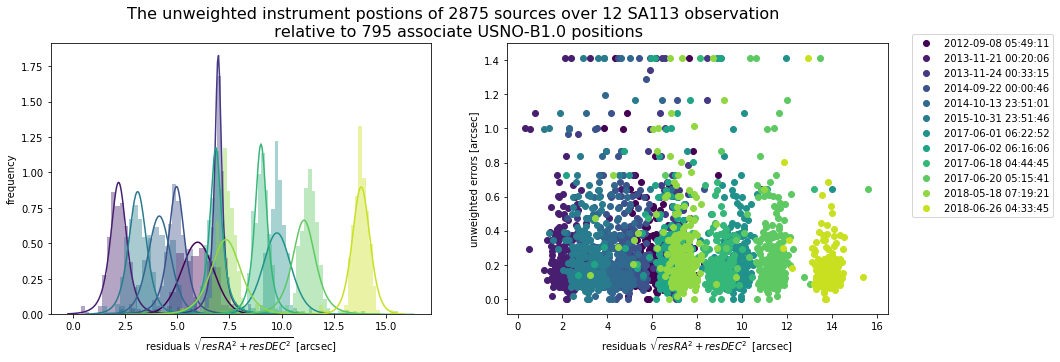

In [9]:
db_Master = "../../mastertable/KiDS/MasterCatalogue_resUSNO.db"

refcat = ['USNO-B1.0', 'GAIA-DR2', 'INSTRUMENT']
origin = ['OmegaCAM SA_113', 'USNO-B1.0', 'GAIA-DR2']

# query_select_masterid = '''SELECT DISTINCT MASTER_ID FROM MasterTable WHERE ORIGIN IS '{}' AND REFCAT IS '{}';'''.format(origin[0], refcat[2])
query_select_masterid = '''SELECT DISTINCT MASTER_ID FROM MasterTable WHERE ORIGIN IS '{}';'''.format(origin[0])
omega_ID = run_query(query_select_masterid, db_file=db_Master, output='array')
query_select_masteridunso = '''SELECT DISTINCT MASTER_ID FROM MasterTable WHERE ORIGIN IS '{}';'''.format(origin[1])
usno_ID = run_query(query_select_masteridunso, db_file=db_Master, output='array')
nr_usno = len(usno_ID)
# Obtaining all MASTER_IDs for which there is an association with UNSO-B1.0
# These sources can be used for our residual analysis according to METHOD 1
both_usno_omega_ID = list(set(omega_ID).intersection(usno_ID))

# Obtaining all MASTER_IDs for which there is no association with UNSO-B1.0
# Most of these sources therefore only have only one source extraction and no refcat
# These sources can be used for our residual analysis according to METHOD 2 [if more than one source extraction per MASTER_ID]
only_omega_ID = list(set(omega_ID).difference(usno_ID))
count = 0

errors = 'unweighted'
residual, resRA, resDec, residual_w, resRA_w, resDec_w = [], [], [], [], [], []
RAs, Decs, timeobs, error, errRA, errDec = [], [], [], [], [], []
residual, residual_w, error, timeobs = [], [], [], []
for master_id in both_usno_omega_ID:
    query_select_SE = '''SELECT MASTER_ID, RA, ERRX2_IMAGE, DEC, ERRY2_IMAGE, TIME_OBS FROM RawMasterTable WHERE ORIGIN IS '{}' AND MASTER_ID IS {};'''.format(origin[0], master_id)
    posSLID = run_query(query_select_SE, db_file=db_Master, output='tuple')
    query_select_CS = '''SELECT MASTER_ID, RA, RA_ERR, DEC, DEC_ERR FROM MasterTable WHERE ORIGIN IS '{}' AND MASTER_ID IS {};'''.format(origin[1], master_id)
    posREF = run_query(query_select_CS, db_file=db_Master, output='tuple')[0]
    count = count + len(posSLID)
    
    diffPosSLID_REF = [np.sqrt( ((  ((source[1]-posREF[1])) * np.cos(posREF[3]) ) *3600 ) **2 + ((source[3]-posREF[3])*3600)**2 ) for idx_source, source in enumerate(posSLID)]
    diffPosErrSLID_REF = [np.sqrt( source[2]**2 + source[4]**2 + (posREF[2]/1000)**2 + (posREF[4]/1000)**2 ) for idx_source, source in enumerate(posSLID)]
        
    res_w = list(np.array(diffPosSLID_REF)/np.array(diffPosErrSLID_REF))  
    res = diffPosSLID_REF
    
    residual_w.extend(res_w)
    residual.extend(res)
    
    RAs.extend(list([source[1] for idx_source, source in enumerate(posSLID)]))
    Decs.extend(list([source[3] for idx_source, source in enumerate(posSLID)]))
    timeobs.extend(list([source[5] for idx_source, source in enumerate(posSLID)]))
    
    error.extend(diffPosErrSLID_REF)
    
time_obs_unique = np.unique(timeobs)
nr_obs = len(time_obs_unique)
fig, axes = plt.subplots(figsize=(15, 5), ncols=2, nrows=1)
fig.suptitle("The {} instrument postions of {} sources over {} SA113 observation \n relative to {} associate USNO-B1.0 positions".format(errors, count, nr_obs, nr_usno), fontsize=16)


viridis = plt.get_cmap('viridis')
cNorm = colors.Normalize(vmin=0, vmax=len(time_obs_unique))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=viridis)

ax = axes[0]
for idx_time, obstime in enumerate(time_obs_unique):
    colorVal = scalarMap.to_rgba(idx_time)
    time_mask = np.where(np.array(timeobs) == str(obstime))
    if errors == 'weighted':
        x = np.array(residual_w)[time_mask]
    elif errors == 'unweighted':
        x = np.array(residual)[time_mask]
    sns.distplot(x, ax=axes[0], fit=fit_distribution, fit_kws={"color":colorVal},  color=colorVal, kde=False)
    (loc, scale) = scipy.stats.norm.fit(x) # df = degrees of freedom
    mean, var = scipy.stats.norm.stats(loc=loc, scale=scale)
ax.set_xlabel(r'residuals $\sqrt{resRA^2+resDEC^2}$ [arcsec]')
ax.set_ylabel('frequency')

ax = axes[1]
for idx_time, obstime in enumerate(time_obs_unique):
    colorVal = scalarMap.to_rgba(idx_time)
    time_mask = np.where(np.array(timeobs) == str(obstime))
    ax.scatter(np.array(residual)[time_mask], np.array(error)[time_mask], color=colorVal, label=obstime)
ax.set_xlabel('residuals $\sqrt{resRA^2+resDEC^2}$ [arcsec]')
ax.set_ylabel('{} errors [arcsec]'.format(errors))

ax.legend(bbox_to_anchor=(1.05, 1.05))

fig.show()




<br><br>

[Go back to list of contents](#LOC)

<a id = "8.3" LOC></a>
***
# Experiment 2: Calibrated USNO-B1.0 versus reference catalogue astrometry
***


<a id = "figure2" LOC></a>


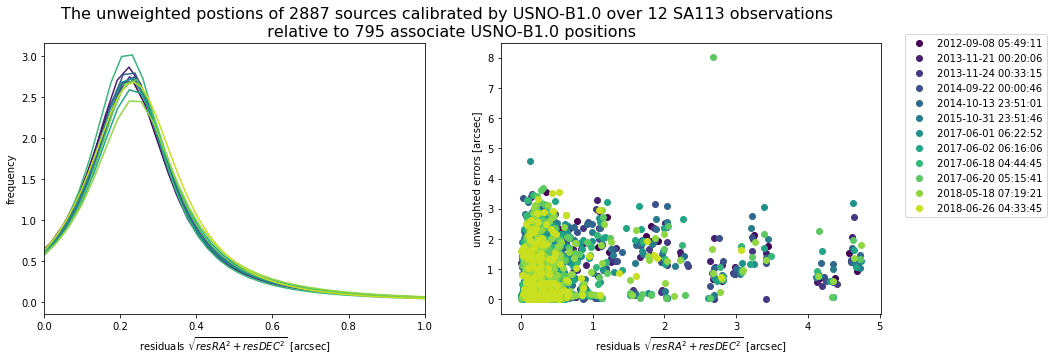

In [16]:
db_Master = "../../mastertable/KiDS/MasterCatalogue_resUSNO.db"

refcat = ['USNO-B1.0', 'GAIA-DR2']
origin = ['OmegaCAM SA_113', 'USNO-B1.0', 'GAIA-DR2']

# query_select_masterid = '''SELECT DISTINCT MASTER_ID FROM MasterTable WHERE ORIGIN IS '{}' AND REFCAT IS '{}';'''.format(origin[0], refcat[0])
query_select_masterid = '''SELECT DISTINCT MASTER_ID FROM MasterTable WHERE ORIGIN IS '{}';'''.format(origin[0])
omega_ID = run_query(query_select_masterid, db_file=db_Master, output='array')
query_select_masteridunso = '''SELECT DISTINCT MASTER_ID FROM MasterTable WHERE ORIGIN IS '{}';'''.format(origin[1])
usno_ID = run_query(query_select_masteridunso, db_file=db_Master, output='array')

# Obtaining all MASTER_IDs for which there is an association with UNSO-B1.0
# These sources can be used for our residual analysis according to METHOD 1
both_usno_omega_ID = list(set(omega_ID).intersection(usno_ID))

# Obtaining all MASTER_IDs for which there is no association with UNSO-B1.0
# Most of these sources therefore only have only one source extraction and no refcat
# These sources can be used for our residual analysis according to METHOD 2 [if more than one source extraction per MASTER_ID]
only_omega_ID = list(set(omega_ID).difference(usno_ID))



errors = 'unweighted' # or unweighted error



residual, residual_w, err = [], [], []
for master_id in both_usno_omega_ID:
    query_select_SE = '''SELECT MASTER_ID, RA, RA_ERR, DEC, DEC_ERR FROM MasterTable WHERE ORIGIN IS '{}' AND MASTER_ID IS {};'''.format(origin[0], master_id)
    posSLID = run_query(query_select_SE, db_file=db_Master, output='tuple')
    query_select_CS = '''SELECT MASTER_ID, RA, RA_ERR, DEC, DEC_ERR FROM MasterTable WHERE ORIGIN IS '{}' AND MASTER_ID IS {};'''.format(origin[1], master_id)
    posREF = run_query(query_select_CS, db_file=db_Master, output='tuple')[0]
    
    diffPosSLID_REF = [np.sqrt( ((  ((source[1]-posREF[1])) * np.cos(posREF[3]) ) *3600 ) **2 + ((source[3]-posREF[3])*3600)**2 ) for idx_source, source in enumerate(posSLID)]

    res = diffPosSLID_REF
    
    residual.extend(res)
    residual_w.extend(res_w)
    
fig, axes = plt.subplots(figsize=(15, 5), ncols=2, nrows=1)
fig.suptitle("The {} postions of {} sources calibrated by USNO-B1.0 over {} SA113 observations \n relative to {} associate USNO-B1.0 positions".format(errors, count, nr_obs, nr_usno), fontsize=16)
ax = axes[0]
for idx_time, obstime in enumerate(time_obs_unique):
    colorVal = scalarMap.to_rgba(idx_time)
    time_mask = np.where(np.array(timeobs) == str(obstime))
    if errors == 'weighted':
        x = np.array(residual_w)[time_mask]
    elif errors == 'unweighted':
        x = np.array(residual)[time_mask]
    sns.distplot(x, ax=axes[0], fit=fit_distribution, fit_kws={"color":colorVal},  color=colorVal, kde=False, hist=False)
    (loc, scale) = scipy.stats.norm.fit(x) # df = degrees of freedom
    mean, var = scipy.stats.norm.stats(loc=loc, scale=scale)
ax.set_xlim(left = 0, right = 1)
ax.set_xlabel(r'residuals $\sqrt{resRA^2+resDEC^2}$ [arcsec]')
ax.set_ylabel('frequency')

ax = axes[1]
for idx_time, obstime in enumerate(time_obs_unique):
    colorVal = scalarMap.to_rgba(idx_time)
    time_mask = np.where(np.array(timeobs) == str(obstime))
    ax.scatter(np.array(residual)[time_mask], np.array(error)[time_mask], color=colorVal, label=obstime)
ax.set_xlabel('residuals $\sqrt{resRA^2+resDEC^2}$ [arcsec]')
ax.set_ylabel('{} errors [arcsec]'.format(errors))

ax.legend(bbox_to_anchor=(1.05, 1.05))

fig.show()







<br><br>

[Go back to list of contents](#LOC)

<a id = "8.4" LOC></a>
***
# Experiment 3: Calibrated GAIA-DR2 versus reference catalogue astrometry
***


<a id = "figure3" LOC></a>


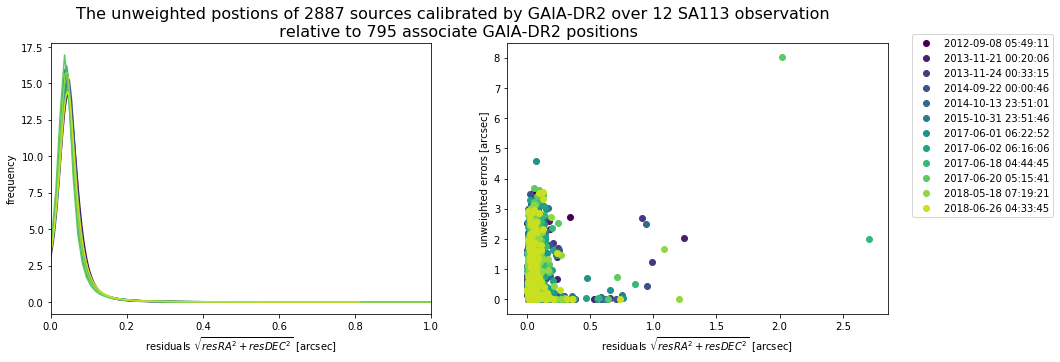

In [13]:
db_Master = "../../mastertable/KiDS/MasterCatalogue_resGAIA.db"

refcat = ['USNO-B1.0', 'GAIA-DR2', 'INSTRUMENT']
origin = ['OmegaCAM SA_113', 'USNO-B1.0', 'GAIA-DR2']

query_select_masterid = '''SELECT DISTINCT MASTER_ID FROM MasterTable WHERE ORIGIN IS '{}' ;'''.format(origin[0])
# print(query_select_masterid)
omega_ID = run_query(query_select_masterid, db_file=db_Master, output='array')
query_select_masteridgaia = '''SELECT DISTINCT MASTER_ID FROM MasterTable WHERE ORIGIN IS '{}';'''.format(origin[2])
# print(query_select_masteridgaia)
gaia_ID = run_query(query_select_masteridgaia, db_file=db_Master, output='array')

# Obtaining all MASTER_IDs for which there is an association with GAIA-DR2
# These sources can be used for our residual analysis according to METHOD 1
both_gaia_omega_ID = list(set(omega_ID).intersection(gaia_ID))

# Obtaining all MASTER_IDs for which there is no association with GAIA-DR2
# Most of these sources therefore only have only one source extraction and no refcat
# These sources can be used for our residual analysis according to METHOD 2 [if more than one source extraction per MASTER_ID]
only_omega_ID = list(set(omega_ID).difference(gaia_ID))
count = 0

residual, resRA, resDec, residual_w, resRA_w, resDec_w = [], [], [], [], [], []
error, errRA, errDec = [], [], []
for master_id in both_gaia_omega_ID:#[:250]:
    query_select_SE = '''SELECT MASTER_ID, RA, RA_ERR, DEC, DEC_ERR, TIME_OBS FROM MasterTable WHERE ORIGIN IS '{}' AND MASTER_ID IS {};'''.format(origin[0], master_id)
    posSLID = run_query(query_select_SE, db_file=db_Master, output='tuple')
    query_select_CS = '''SELECT MASTER_ID, RA, RA_ERR, DEC, DEC_ERR FROM MasterTable WHERE ORIGIN IS '{}' AND MASTER_ID IS {};'''.format(origin[2], master_id)
    posREF = run_query(query_select_CS, db_file=db_Master, output='tuple')[0]
    count = count + len(posSLID)
    
    diffPosSLID_REF = [np.sqrt( ((  ((source[1]-posREF[1])) * np.cos(posREF[3]) ) *3600 ) **2 + ((source[3]-posREF[3])*3600)**2 ) for idx_source, source in enumerate(posSLID)]

    diffPosErrSLID_REF = [np.sqrt( source[2]**2 + source[4]**2 + (posREF[2]/1000)**2 + (posREF[4]/1000)**2 ) for idx_source, source in enumerate(posSLID)]
    
    diffRASLID_REF = [ (source[1]-posREF[1])*3600 for idx_source, source in enumerate(posSLID)]
    diffRAErrSLID_REF = [ np.sqrt((source[2]**2+(posREF[2]/1000)**2)) for idx_source, source in enumerate(posSLID)]
    diffDecSLID_REF = [ (source[3]-posREF[3])*3600 for idx_source, source in enumerate(posSLID)]
    diffDecErrSLID_REF = [ np.sqrt((source[4]**2+(posREF[4]/1000)**2)) for idx_source, source in enumerate(posSLID)]
    
    res_w = list(np.array(diffPosSLID_REF)/np.array(diffPosErrSLID_REF))
    resR_w = list(np.array(diffRASLID_REF)/np.array(diffRAErrSLID_REF))
    resD_w = list(np.array(diffDecSLID_REF)/np.array(diffDecErrSLID_REF))
    
    res = diffPosSLID_REF
    resR = diffRASLID_REF
    resD = diffDecSLID_REF
    
    residual_w.extend(res_w)
    resRA_w.extend(resR_w)
    resDec_w.extend(resD_w)   
    
    residual.extend(res)
    resRA.extend(resR)
    resDec.extend(resD)
    
    error.extend(diffPosErrSLID_REF)
    errRA.extend(diffRAErrSLID_REF)
    errDec.extend(diffDecErrSLID_REF)
    
time_obs_unique = np.unique(timeobs)

fig, axes = plt.subplots(figsize=(15, 5), ncols=2, nrows=1)
fig.suptitle("The {} postions of {} sources calibrated by GAIA-DR2 over {} SA113 observation \n relative to {} associate GAIA-DR2 positions".format(errors, count, nr_obs, nr_usno), fontsize=16)
ax = axes[0]

viridis = plt.get_cmap('viridis')
cNorm = colors.Normalize(vmin=0, vmax=len(time_obs_unique))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=viridis)

for idx_time, obstime in enumerate(time_obs_unique):
    colorVal = scalarMap.to_rgba(idx_time)
    time_mask = np.where(np.array(timeobs) == str(obstime))
    if errors == 'weighted':
        x = np.array(residual_w)[time_mask]
    elif errors == 'unweighted':
        x = np.array(residual)[time_mask]
    sns.distplot(x, ax=axes[0], fit=fit_distribution, fit_kws={"color":colorVal},  color=colorVal, kde=False, hist=False)
    (loc, scale) = scipy.stats.norm.fit(x) # df = degrees of freedom
    mean, var = scipy.stats.norm.stats(loc=loc, scale=scale)
ax.set_xlim(left = 0, right = 1)
ax.set_xlabel(r'residuals $\sqrt{resRA^2+resDEC^2}$ [arcsec]')
ax.set_ylabel('frequency')

ax = axes[1]
for idx_time, obstime in enumerate(time_obs_unique):
    colorVal = scalarMap.to_rgba(idx_time)
    time_mask = np.where(np.array(timeobs) == str(obstime))
    ax.scatter(np.array(residual)[time_mask], np.array(error)[time_mask], color=colorVal, label=obstime)
ax.set_xlabel('residuals $\sqrt{resRA^2+resDEC^2}$ [arcsec]')
ax.set_ylabel('{} errors [arcsec]'.format(errors))

ax.legend(bbox_to_anchor=(1.05, 1.05))

fig.show()


print_filterinfo = "no"
print_table_indu = "no"
print_table_toge = "no"


header = "| {:^18s} | {:^10s} | {:^10s} | {:^10s} | {:^10s} |".format("Observation Date",  "Residual of",  "Mean RES", "Median RES", "Std RES")

if print_filterinfo == "yes":
    print('Table showing the statistics of the residual distributions as plotted in the Figures')
    print('GAIA-DR2 CALIBRATED SA113 SOURCE EXTRACTIONS VERSUS GAIA-DR2 CELESTIAL OBJECTS')
    print('All values in the table are in [arcsec]')

if print_table_indu == "yes":
    print(header)
    print("|:-------------------:|:--------:|:------------:|:------------:|:------------:|:------------:|")
    res_types = ["RA", "Dec", "Position"]
    R = [resRA, resDec, residual]
    eR = [errRA, errDec, error]
    for idx_type, res_type in enumerate(res_types):
        for idx_time, obstime in enumerate(time_obs_unique):
            time_mask = np.where(np.array(timeobs) == str(obstime))
            x = np.array(R[idx_type])[time_mask]
            e = np.array(eR[idx_type])[time_mask]
            
            (loc, scale) = scipy.stats.norm.fit(x) # df = degrees of freedom
            mean, var = scipy.stats.norm.stats(loc=loc, scale=scale)

            s = "| {:^18s} | {:^8s} | {:12.2f} | {:12.2f} | {:12.2f} | {:12.2f} |".format(obstime, res_type, mean, np.median(x), var**0.5, np.mean(e))
            print(s)
        print("|---------------------|----------|--------------|--------------|--------------|--------------|")

header = "| {:^18s} | {:^10s} | {:^10s} | {:^10s} | {:^10s} | {:^10s} | {:^10s} | {:^10s} | {:^10s} | {:^10s} | {:^10s} | {:^10s} | {:^10s} |".format("Observation Date",  "Mean RA", "Median RA", "Std RA", "error RA", "Mean DEC", "Median DEC", "Std DEC", "error DEC", "Mean POS", "Median POS", "Std POS", "error POS" )

if print_table_toge == "yes":
    print(header)
    print("|:-------------------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|")
    res_types = ["RA", "Dec", "Position"]
    R = [resRA, resDec, residual]
    eR = [errRA, errDec, error]
    for idx_time, obstime in enumerate(time_obs_unique):
        time_mask = np.where(np.array(timeobs) == str(obstime))
        x_ra, e_ra = np.array(resRA)[time_mask], np.array(errRA)[time_mask]
        x_dec, e_dec = np.array(resDec)[time_mask], np.array(errDec)[time_mask]
        x_all, e_all = np.array(residual)[time_mask], np.array(error)[time_mask]
        stats = []
        for x in [x_ra, x_dec, x_all]:
            (loc, scale) = scipy.stats.norm.fit(x) # df = degrees of freedom
            mean, var = scipy.stats.norm.stats(loc=loc, scale=scale)
            stats.append((mean, var))
        s = "| {:^18s} | {:6.3f} | {:6.3f} | {:6.3f} | {:6.3f} | {:6.3f} | {:6.3f} | {:6.3f} | {:6.3f} | {:6.3f} | {:6.3f} | {:6.3f} | {:6.3f} |".format(obstime, stats[0][0], np.median(x_ra), stats[0][1]**0.5, np.mean(errRA), stats[1][0], np.median(x_dec), stats[1][1]**0.5, np.mean(errDec), stats[2][0], np.median(x_all), stats[2][1]**0.5, np.mean(error))
        print(s)
    print("|---------------------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|")





<br><br>

[Go back to list of contents](#LOC)

<a id = "8.5" LOC></a>
***
# Conclusions of Residual Analyses
***


We see a clear improvement in both accuracy and precision when comparing the position residuals for experiment 1, 2 and 3.  

* The accuracy went up from instrumental $\sim 14$ mas to $\sim 0.2$ mas to $\sim 0.1$ mas for GAIA-DR2 calibrated residuals. 
* The precision improved from respectively $\sim 2.5$ mas, $\sim 0.6$ mas up to $\sim 0.2$ mas
* This reveals the importance of calibrating $\texttt{DetectorImage}$s to reference stars on the sky. 
* The improvement from USNO-B1.0 to GAIA-DR2 calibrated residuals reveals the importance of calibrating to an accurate reference catalogue. Both the accuracy and precision's were improved by a factor 2.